# Posterior Predictive Checks

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
from jax import random
import scipy.stats as st
import arviz as az

D:\dev\playground\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
rng = np.random.default_rng(0)
sample = rng.poisson(10, 252)
sample_next_year = rng.poisson(12, 252)

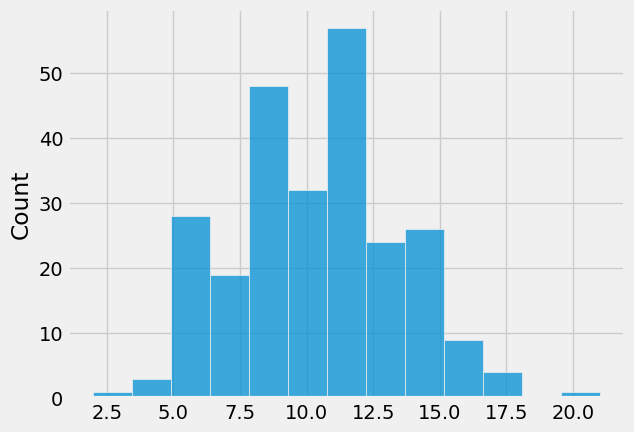

In [3]:
sns.histplot(sample);

In [4]:
def model(obs=None, num_obs=None):
    alpha = 1
    beta = 0.1
    λ = numpyro.sample("λ", dist.Gamma(alpha, beta))
    with numpyro.plate('observation', num_obs):
        numpyro.sample("obs", dist.Poisson(λ), obs=obs)

In [5]:
nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=2000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, obs=sample, num_obs=len(sample))

posterior_samples = mcmc.get_samples()

sample: 100%|█| 4000/4000 [00:05<00:00, 681.08it/s, 7 steps of size 8.36e-01. a


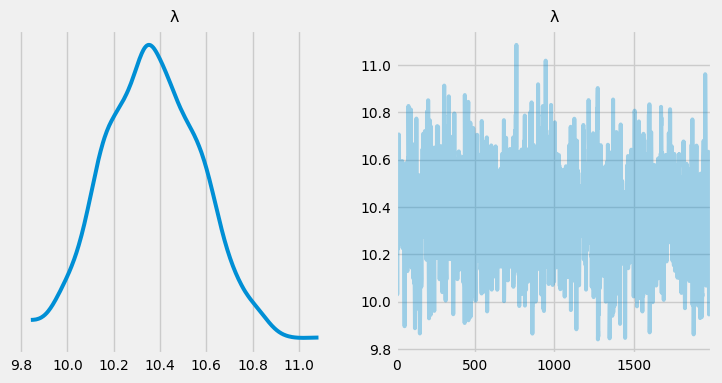

In [6]:
data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True, figsize=(8, 4));

## Generate posterior predictive data

In [7]:
predictive = Predictive(model, posterior_samples, return_sites=["obs", "λ"])

In [8]:
num_obs = 252
post_pred_data = predictive(rng_key, obs = None, num_obs = num_obs)

<AxesSubplot: xlabel='obs / obs'>

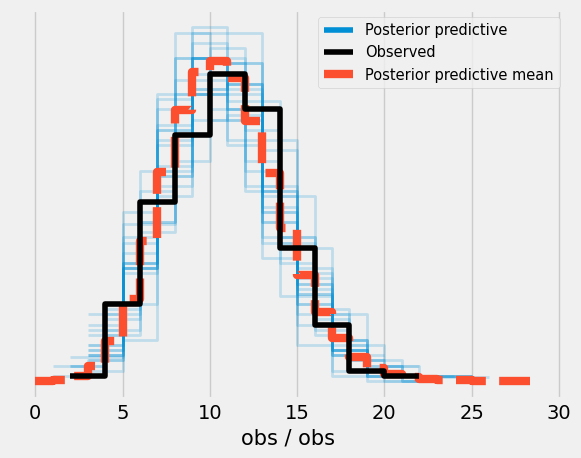

In [9]:
data_for_plotting = az.from_numpyro(
    posterior = mcmc,
    posterior_predictive=post_pred_data
)
az.plot_ppc(data_for_plotting, num_pp_samples=20)

## Define the statistic of interest

In [10]:
T = lambda x: np.quantile(x, 0.99)  # 99th quantile of the data

## Define the discrepancy

In [11]:
D = lambda x, lam: sum ((x-lam)**2 / lam)

## Calculate "Bayesian p-value"

In [12]:
sum(np.asarray([T(i) for i in post_pred_data["obs"]]) >= T(sample)) / post_pred_data["obs"].shape[0]

0.858

In [13]:
D_obs = np.asarray([D(sample, i) for i in post_pred_data["λ"]])

In [14]:
D_rep = np.asarray([D(j, i) for i,j in zip(post_pred_data["λ"], post_pred_data["obs"])])

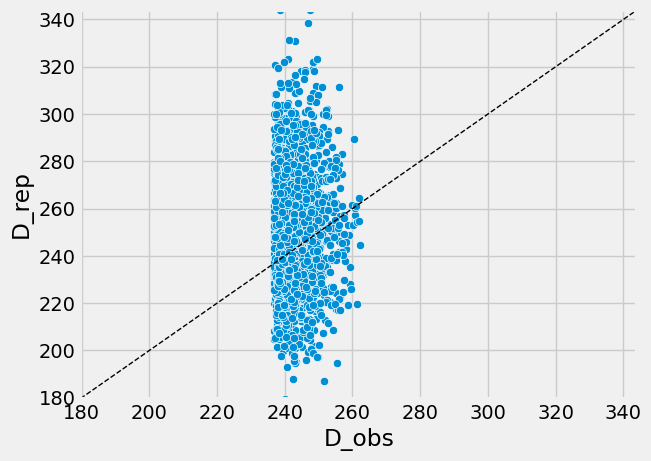

In [15]:
data = pd.DataFrame(np.asarray([D_obs, D_rep]).T, columns=["D_obs", "D_rep"])
fig, ax = plt.subplots()
mi, ma = min(min(D_obs), min(D_rep)), max(max(D_obs), max(D_rep))
sns.scatterplot(data, x="D_obs", y="D_rep", ax=ax)
ax.axline([0, 0], [1, 1], c="black", ls="--", lw=1)
ax.set_ylim(mi, ma), ax.set_xlim(mi, ma);

In [16]:
sum(D_rep >= D_obs) / len(D_rep)

0.6315

## Same for the next year's data

In [17]:
sum(np.asarray([T(i) for i in post_pred_data["obs"]]) >= T(sample_next_year)) / post_pred_data["obs"].shape[0]

0.016

In [18]:
D_obs = np.asarray([D(sample_next_year, i) for i in post_pred_data["λ"]])

In [19]:
D_rep = np.asarray([D(j, i) for i,j in zip(post_pred_data["λ"], post_pred_data["obs"])])

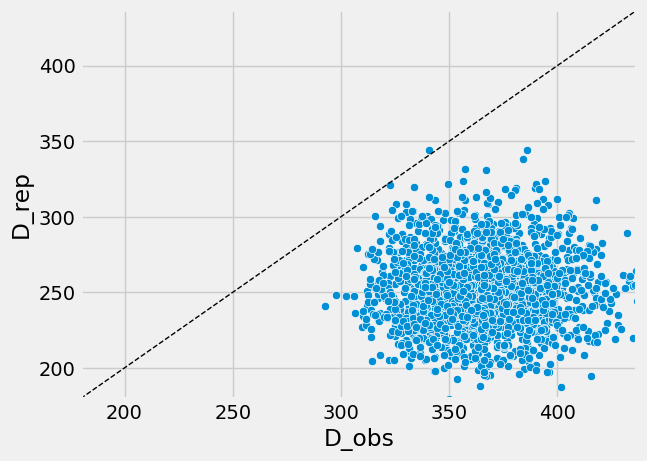

In [20]:
data = pd.DataFrame(np.asarray([D_obs, D_rep]).T, columns=["D_obs", "D_rep"])
fig, ax = plt.subplots()
mi, ma = min(min(D_obs), min(D_rep)), max(max(D_obs), max(D_rep))
sns.scatterplot(data, x="D_obs", y="D_rep", ax=ax)
ax.axline([0, 0], [1, 1], c="black", ls="--", lw=1)
ax.set_ylim(mi, ma), ax.set_xlim(mi, ma);

In [21]:
sum(D_rep >= D_obs) / len(D_rep)

0.0005